In [2]:
from prophet import Prophet
import itertools
from prophet.diagnostics import cross_validation, performance_metrics
import plotly.offline as py
import matplotlib as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import holidays
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [3]:
# Defining training and test
training_upto = 2021
forecast_upto = (2023-training_upto-1)*12 +3

In [4]:
# Getting Holidays
holiday = pd.DataFrame([])
for date, name in sorted(holidays.country_holidays('GB', subdiv='England', years=[2012, 2013, 2014, 2015, 2016, 2017, 2018,2019,2020,2021, 2022, 2023, 2024]).items()):
    holiday= pd.concat([holiday, pd.DataFrame({'ds': date, 'holiday': "England-Holidays"}, index=[0])], ignore_index=True)

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

## Prediction Whole of Barnet

In [4]:
# Read data, get dataframe with crimes/month
monthly_grouped_df = pd.read_csv('C:\\Users\\20203697\\Downloads\\filtered_df_utility_cols.csv')
monthly_grouped_df= monthly_grouped_df.sort_values(['Year','Month num'],ascending=False).groupby(['Year', 'Month num'])['Crime type'].count()
monthly_grouped_df = monthly_grouped_df.to_frame()


# Rename columns, select rows with data and set datetime index
monthly_grouped_df = monthly_grouped_df.rename(columns = {'Month num':'y'})
monthly_grouped_df['day'] = 1
monthly_grouped_df = monthly_grouped_df.reset_index()
monthly_grouped_df = monthly_grouped_df.rename(columns={'Month num': 'month', 'Year': 'year'})
monthly_grouped_df['ds'] = pd.to_datetime(monthly_grouped_df[['year', 'month', 'day']])
monthly_grouped_df['y'] = monthly_grouped_df['Crime type']
monthly_grouped_df['covid']  = 0
monthly_grouped_df['covid'][((monthly_grouped_df['year']==2020) & (monthly_grouped_df['month']>2)) | ((monthly_grouped_df['year']==2021)& (monthly_grouped_df['month']<6))]

# Divide test and train data
train_data = monthly_grouped_df[monthly_grouped_df['year']<(training_upto+1)]
test_data = monthly_grouped_df[(monthly_grouped_df['year']>training_upto)]

### Hyper-parameter tuning

In [11]:
# Defining the parameters & values to be tuned
param_grid = { 
    'seasonality_mode':('multiplicative','additive'), 
    'changepoint_prior_scale': [0.5, 0.1, 1,0.01],
    'seasonality_prior_scale': [0.5, 0.1, 1, 0.01],
    'holidays_prior_scale':[1, 10, 25, 50],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = []  # Store the RMSEs for each params here

cutoffs = pd.date_range(start='2015-01-01', end='2021-12-01', freq='2MS')

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params, holidays= holiday).fit(monthly_grouped_df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    maes.append(df_p['mae'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes
print("Mean absolute error: ", np.argmin(maes))
best_params = all_params[np.argmin(maes)]
print("Best parameters", best_params)

14:02:10 - cmdstanpy - INFO - Chain [1] start processing
14:02:10 - cmdstanpy - INFO - Chain [1] done processing
14:02:38 - cmdstanpy - INFO - Chain [1] start processing
14:02:38 - cmdstanpy - INFO - Chain [1] done processing
14:03:03 - cmdstanpy - INFO - Chain [1] start processing
14:03:03 - cmdstanpy - INFO - Chain [1] done processing
14:03:26 - cmdstanpy - INFO - Chain [1] start processing
14:03:26 - cmdstanpy - INFO - Chain [1] done processing
14:03:48 - cmdstanpy - INFO - Chain [1] start processing
14:03:48 - cmdstanpy - INFO - Chain [1] done processing
14:04:09 - cmdstanpy - INFO - Chain [1] start processing
14:04:09 - cmdstanpy - INFO - Chain [1] done processing
14:04:30 - cmdstanpy - INFO - Chain [1] start processing
14:04:30 - cmdstanpy - INFO - Chain [1] done processing
14:04:50 - cmdstanpy - INFO - Chain [1] start processing
14:04:50 - cmdstanpy - INFO - Chain [1] done processing
14:05:09 - cmdstanpy - INFO - Chain [1] start processing
14:05:09 - cmdstanpy - INFO - Chain [1]

Mean absolute error:  59
Best parameters {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1, 'holidays_prior_scale': 50}


16:45:10 - cmdstanpy - INFO - Chain [1] start processing
16:45:10 - cmdstanpy - INFO - Chain [1] done processing


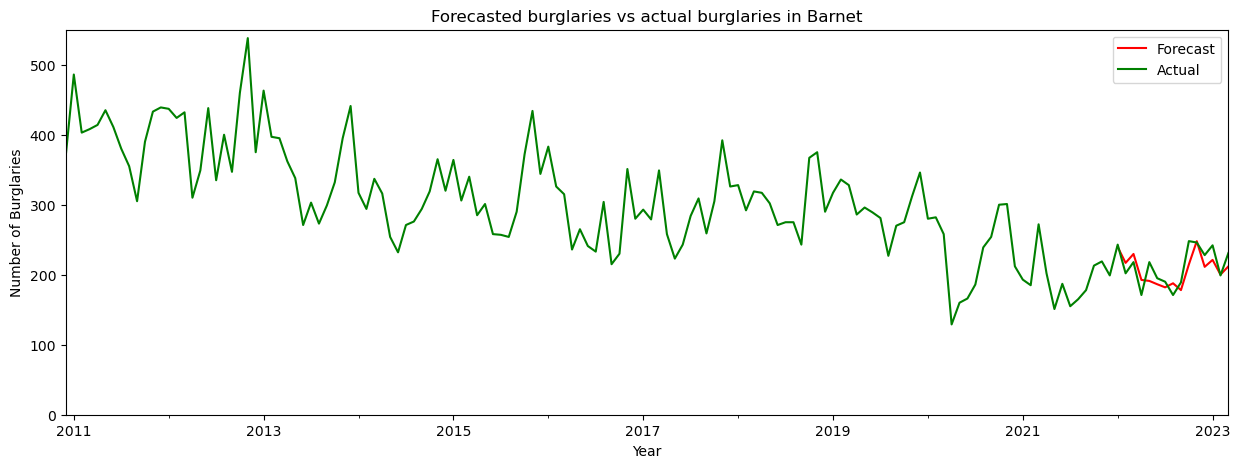

MAE 14.379002243731367
MSE 285.9073727833348
R2 0.5679823317288297


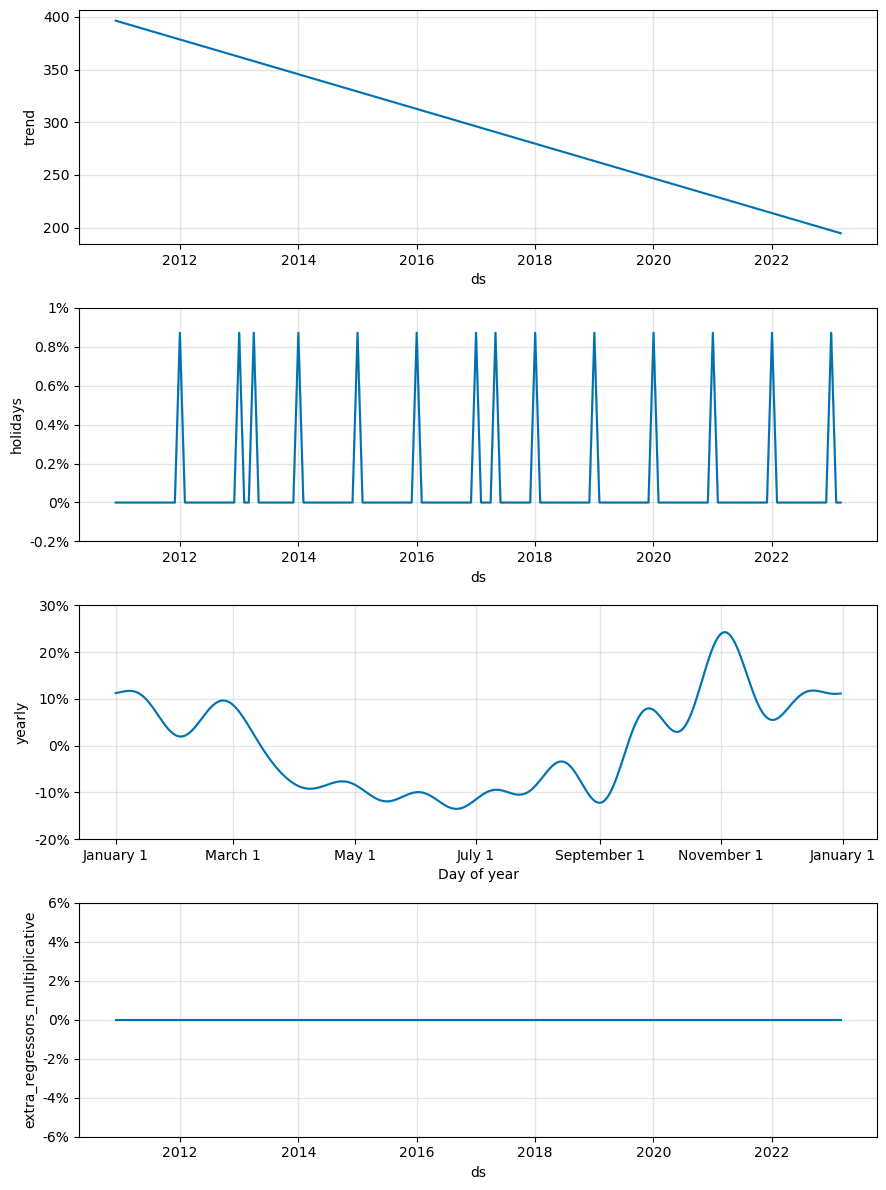

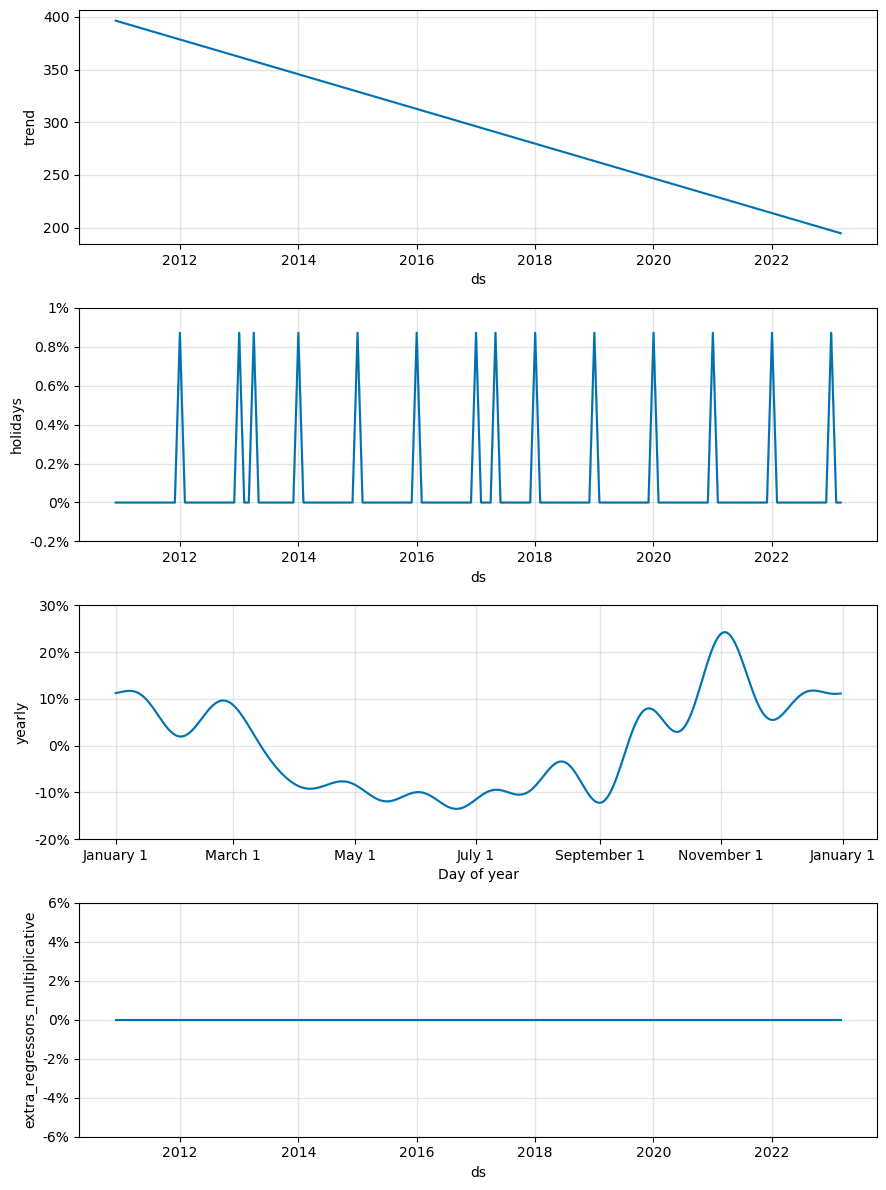

In [20]:
# Train the model with the best parameters and forecast
best_model = Prophet(seasonality_mode= 'multiplicative', changepoint_prior_scale= 0.01, seasonality_prior_scale= 1, holidays_prior_scale= 50, holidays= holiday)
best_model.add_regressor('covid')
best_model.fit(train_data)
future_dates = best_model.make_future_dataframe(periods=forecast_upto, freq='MS')
future_dates['covid'] = 0
forecast = best_model.predict(future_dates)

# Plot predictions
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
forecast[-forecast_upto:].plot(kind='line',x='ds', y='yhat', color='red', label='Forecast', ax=ax)
monthly_grouped_df.plot(kind='line',x='ds',y='y', color='green',label='Actual', ax=ax)
plt.title('Forecasted burglaries vs actual burglaries in Barnet')
plt.xlabel("Year")
plt.ylabel("Number of Burglaries")
plt.ylim(0,550)
plt.show()

print("MAE", mean_absolute_error(test_data['y'], forecast['yhat'][-forecast_upto:]))
print("MSE", mean_squared_error(test_data['y'], forecast['yhat'][-forecast_upto:]))
print("R2", r2_score(test_data['y'], forecast['yhat'][-forecast_upto:]))

best_model.plot_components(forecast)

## Prediction per ward

In [5]:
# Create the dataframe
file =  pd.read_csv('C:/Users/20203697/Downloads/filtered_df_utility_cols.csv')
df_per_ward= file.sort_values(['Year','Month num'],ascending=False).groupby(['Ward', 'Year', 'Month num']).count()

# Create a dataframe with the wanted dates
dates = pd.date_range(start='12/1/2010', end='3/1/2023', freq='MS').to_frame()
df_per_ward = df_per_ward.reset_index()

# Specify columns: ds, y, Date, covid
df_per_ward['day'] = 1
df_per_ward = df_per_ward.reset_index()
df_per_ward['y'] = df_per_ward['Crime type']
df_per_ward = df_per_ward.rename(columns={'Month num': 'month', 'Year': 'year'})
df_per_ward['ds'] = pd.to_datetime(df_per_ward[['year', 'month', 'day']])
df_per_ward['Date'] = df_per_ward['ds']
df_per_ward['covid']  = 0
df_per_ward['covid'][((df_per_ward['year']==2020) & (df_per_ward['month']>2)) | ((df_per_ward['year']==2021)& (df_per_ward['month']<6))]
dates['Date'] = dates[0]
dates = dates[['Date']]

24


C:\Users\20203697\AppData\Local\Temp\ipykernel_21228\3932083734.py:28: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

16:52:02 - cmdstanpy - INFO - Chain [1] start processing
16:52:03 - cmdstanpy - INFO - Chain [1] done processing


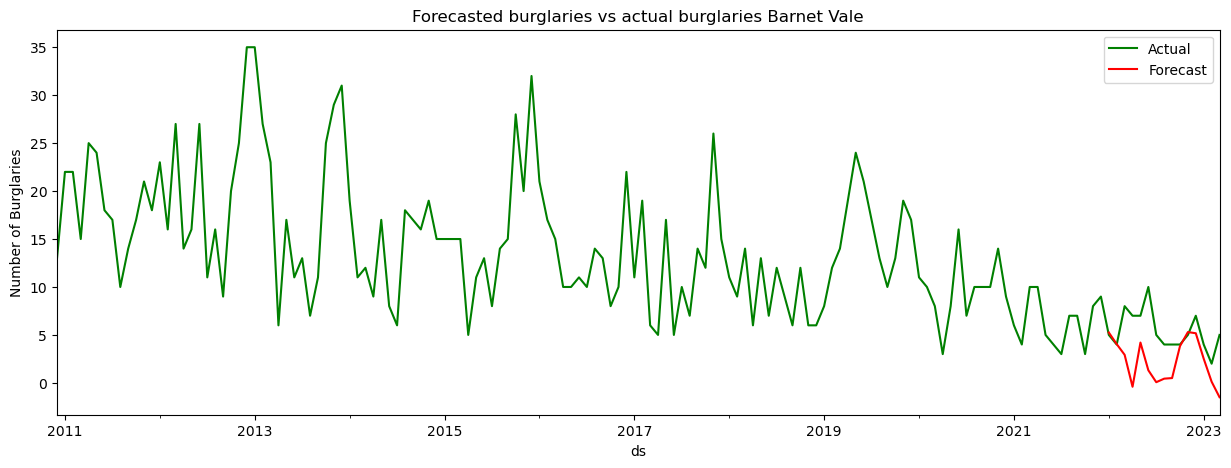

C:\Users\20203697\AppData\Local\Temp\ipykernel_21228\3932083734.py:28: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

16:52:03 - cmdstanpy - INFO - Chain [1] start processing
16:52:04 - cmdstanpy - INFO - Chain [1] done processing


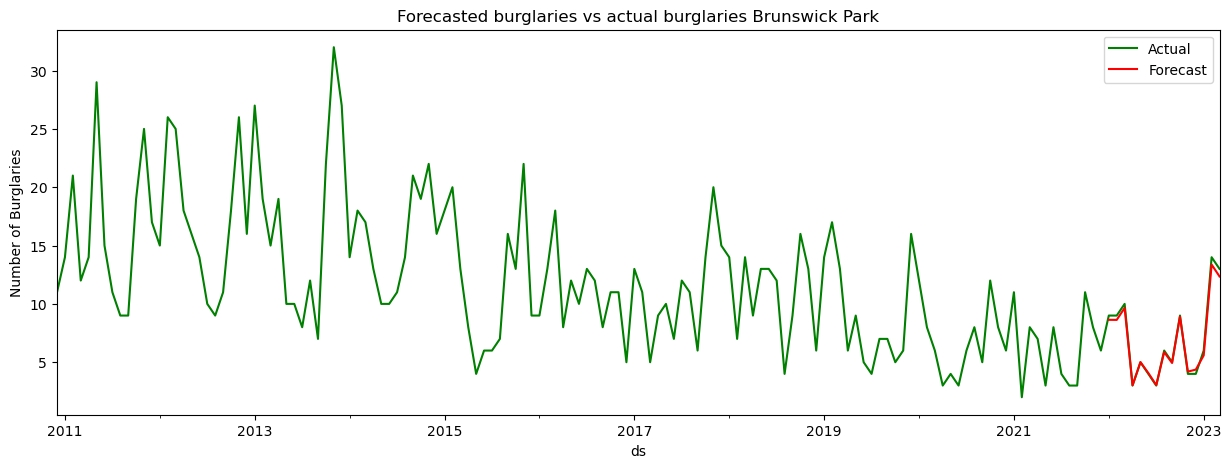

C:\Users\20203697\AppData\Local\Temp\ipykernel_21228\3932083734.py:28: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

16:52:05 - cmdstanpy - INFO - Chain [1] start processing
16:52:05 - cmdstanpy - INFO - Chain [1] done processing


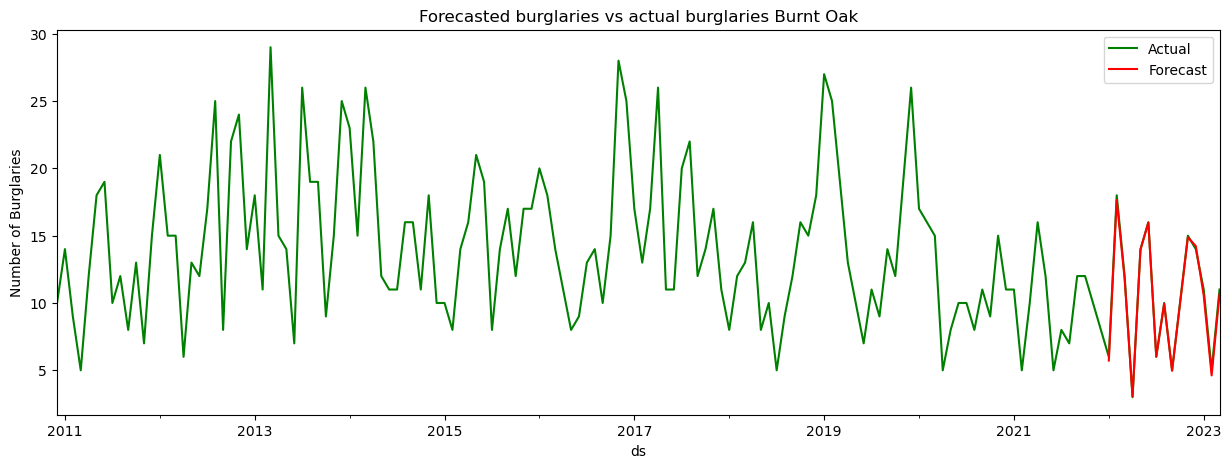

C:\Users\20203697\AppData\Local\Temp\ipykernel_21228\3932083734.py:28: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

16:52:06 - cmdstanpy - INFO - Chain [1] start processing
16:52:06 - cmdstanpy - INFO - Chain [1] done processing


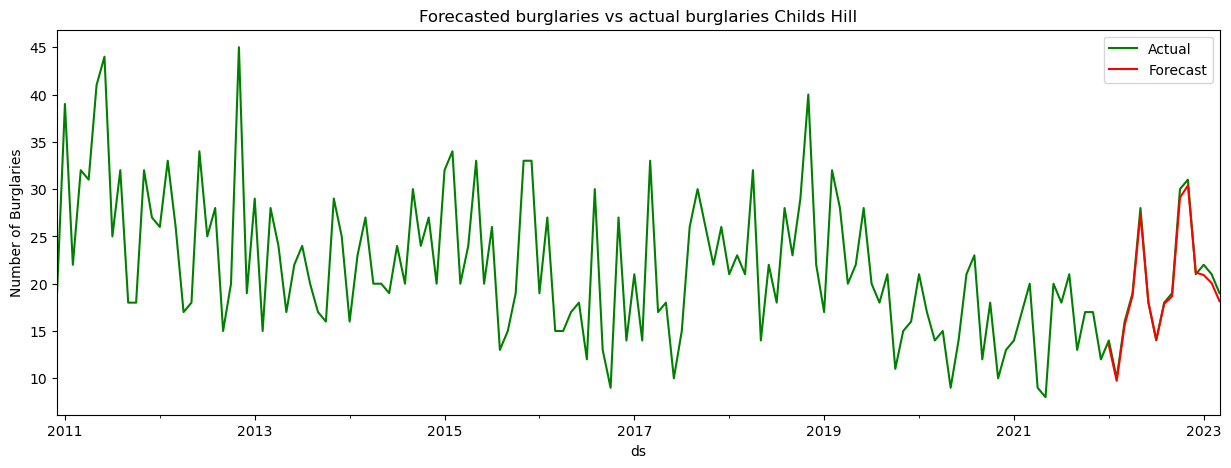

C:\Users\20203697\AppData\Local\Temp\ipykernel_21228\3932083734.py:28: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

16:52:07 - cmdstanpy - INFO - Chain [1] start processing
16:52:07 - cmdstanpy - INFO - Chain [1] done processing


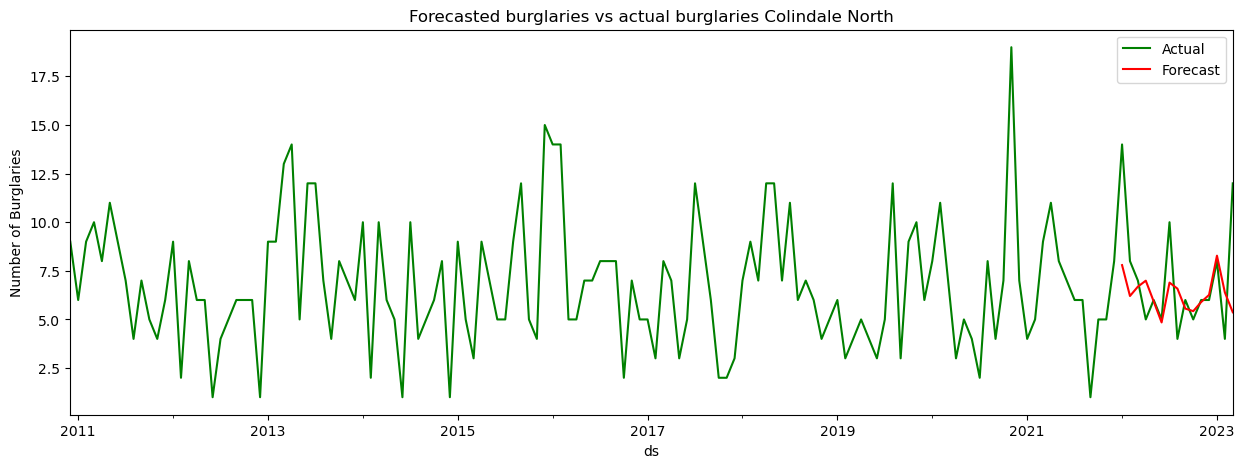

C:\Users\20203697\AppData\Local\Temp\ipykernel_21228\3932083734.py:28: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

16:52:08 - cmdstanpy - INFO - Chain [1] start processing
16:52:08 - cmdstanpy - INFO - Chain [1] done processing


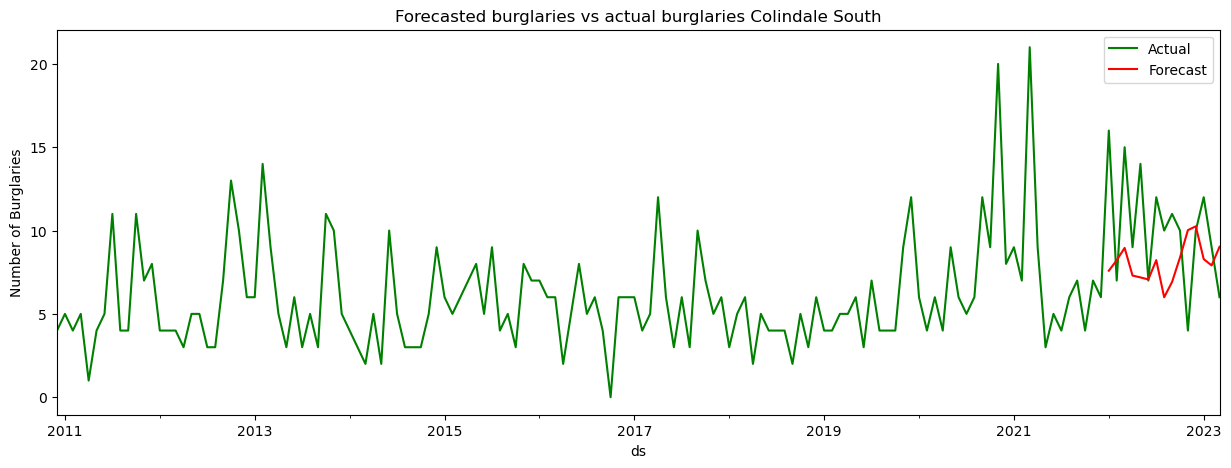

C:\Users\20203697\AppData\Local\Temp\ipykernel_21228\3932083734.py:28: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

16:52:09 - cmdstanpy - INFO - Chain [1] start processing
16:52:09 - cmdstanpy - INFO - Chain [1] done processing


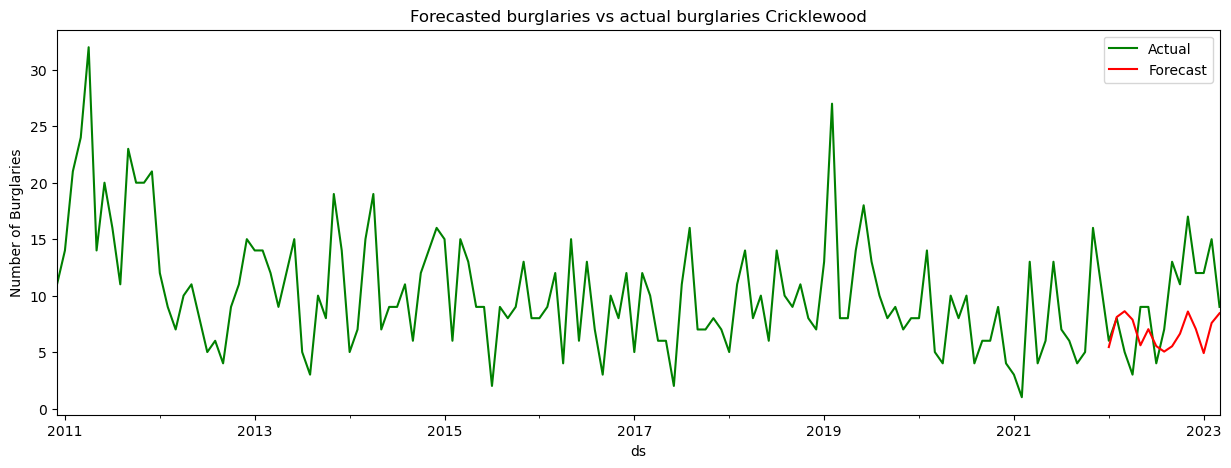

C:\Users\20203697\AppData\Local\Temp\ipykernel_21228\3932083734.py:28: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

16:52:10 - cmdstanpy - INFO - Chain [1] start processing
16:52:10 - cmdstanpy - INFO - Chain [1] done processing


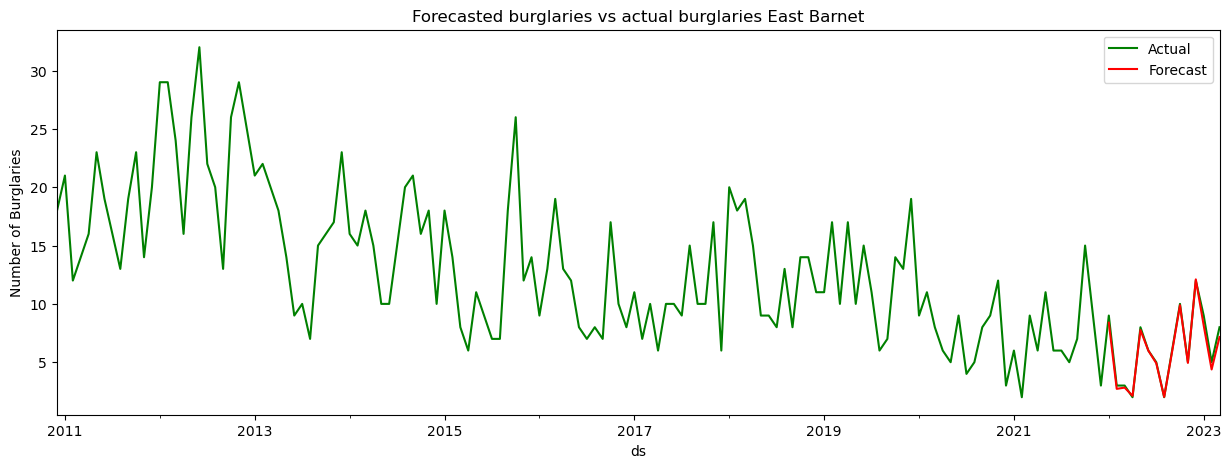

C:\Users\20203697\AppData\Local\Temp\ipykernel_21228\3932083734.py:28: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

16:52:11 - cmdstanpy - INFO - Chain [1] start processing
16:52:11 - cmdstanpy - INFO - Chain [1] done processing


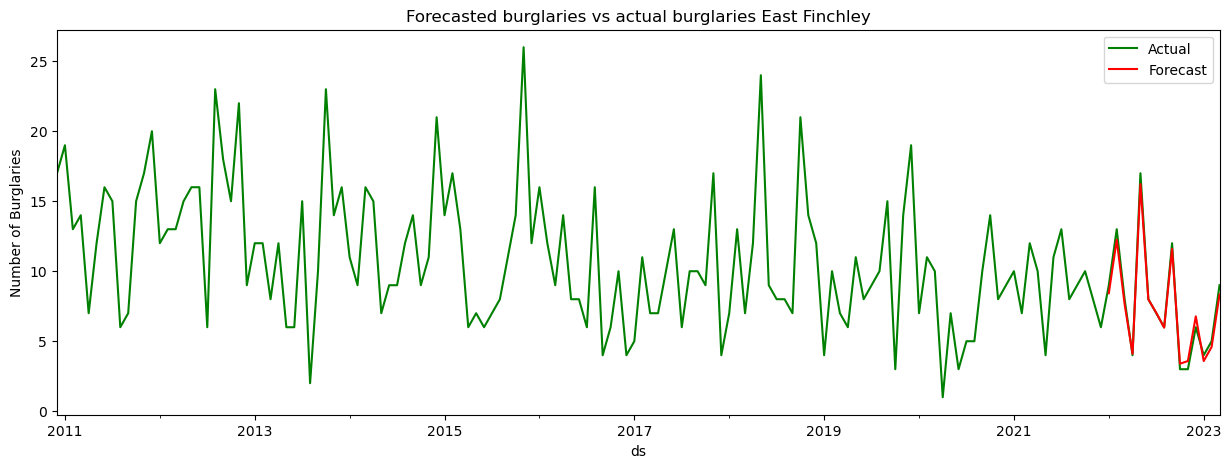

C:\Users\20203697\AppData\Local\Temp\ipykernel_21228\3932083734.py:28: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

16:52:12 - cmdstanpy - INFO - Chain [1] start processing
16:52:12 - cmdstanpy - INFO - Chain [1] done processing


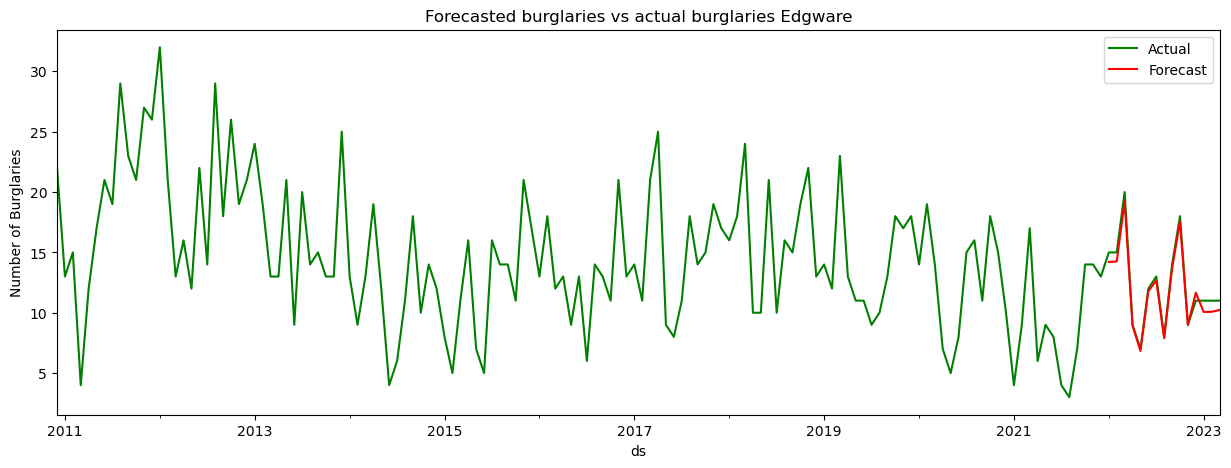

C:\Users\20203697\AppData\Local\Temp\ipykernel_21228\3932083734.py:28: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

16:52:13 - cmdstanpy - INFO - Chain [1] start processing
16:52:13 - cmdstanpy - INFO - Chain [1] done processing


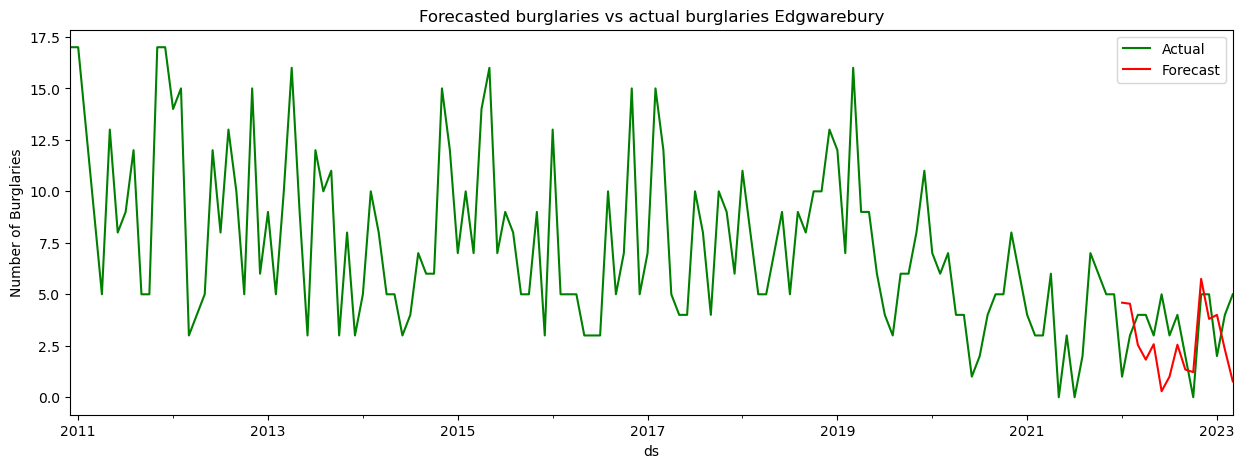

C:\Users\20203697\AppData\Local\Temp\ipykernel_21228\3932083734.py:28: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

16:52:14 - cmdstanpy - INFO - Chain [1] start processing
16:52:14 - cmdstanpy - INFO - Chain [1] done processing


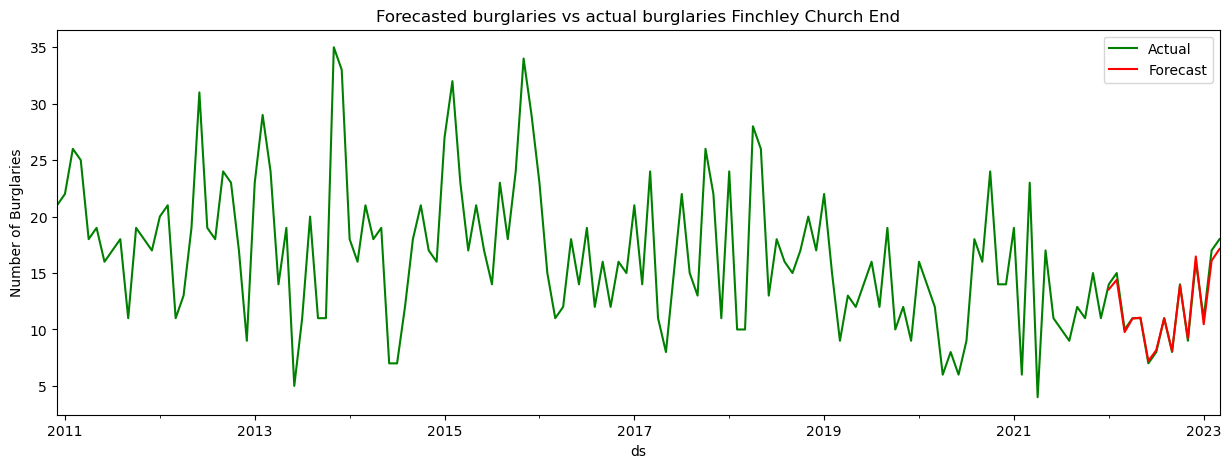

C:\Users\20203697\AppData\Local\Temp\ipykernel_21228\3932083734.py:28: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

16:52:15 - cmdstanpy - INFO - Chain [1] start processing
16:52:15 - cmdstanpy - INFO - Chain [1] done processing


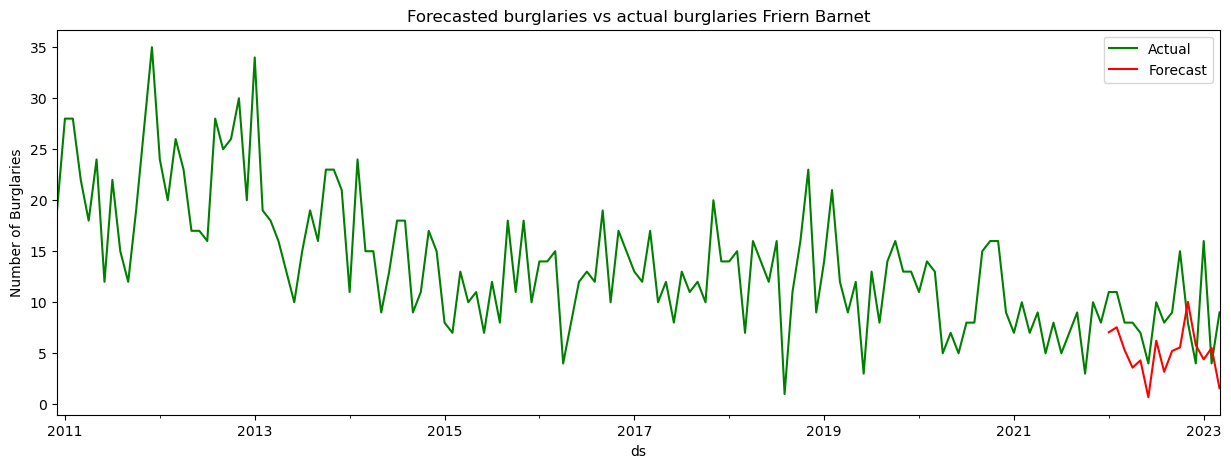

C:\Users\20203697\AppData\Local\Temp\ipykernel_21228\3932083734.py:28: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

16:52:16 - cmdstanpy - INFO - Chain [1] start processing
16:52:16 - cmdstanpy - INFO - Chain [1] done processing


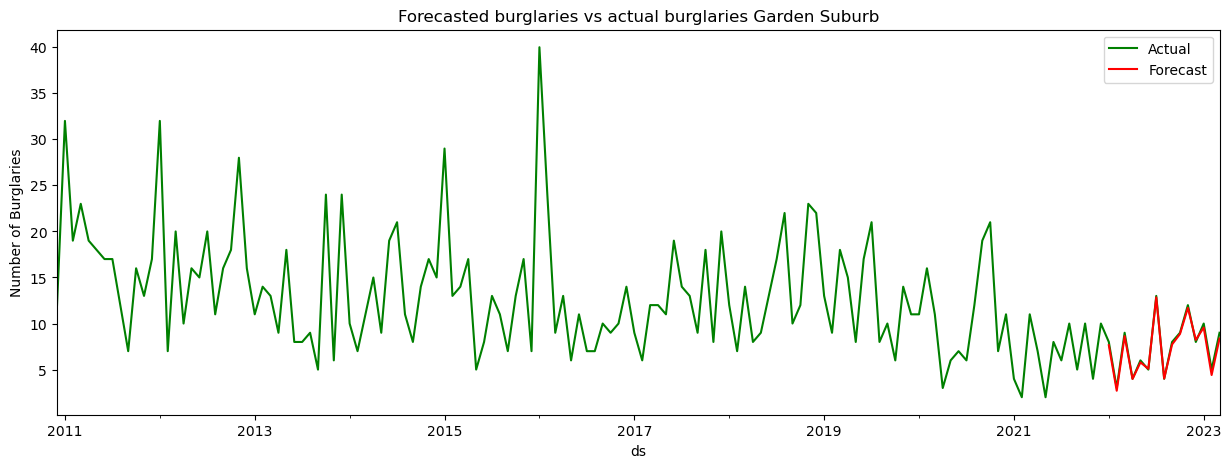

C:\Users\20203697\AppData\Local\Temp\ipykernel_21228\3932083734.py:28: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

16:52:17 - cmdstanpy - INFO - Chain [1] start processing
16:52:17 - cmdstanpy - INFO - Chain [1] done processing


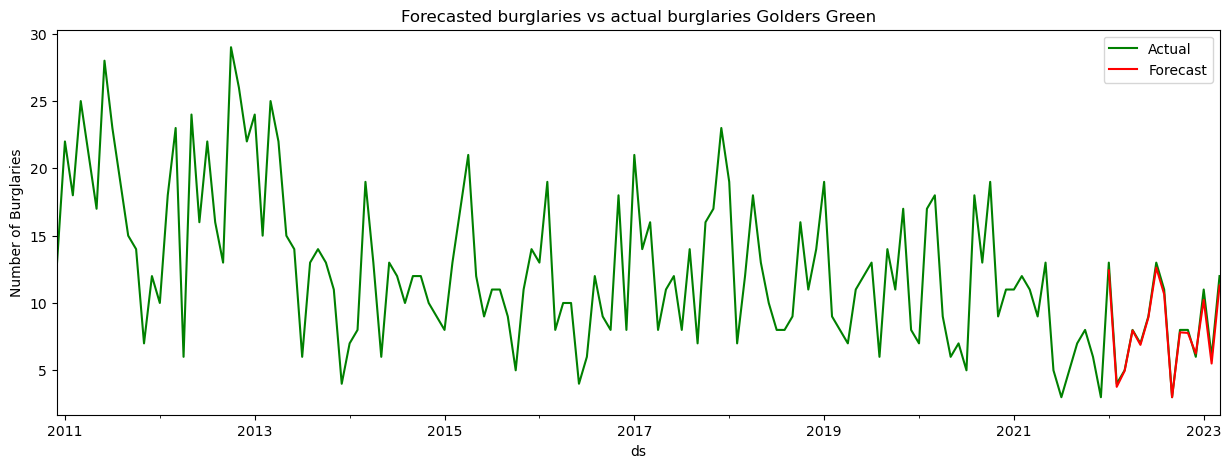

C:\Users\20203697\AppData\Local\Temp\ipykernel_21228\3932083734.py:28: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

16:52:18 - cmdstanpy - INFO - Chain [1] start processing
16:52:18 - cmdstanpy - INFO - Chain [1] done processing


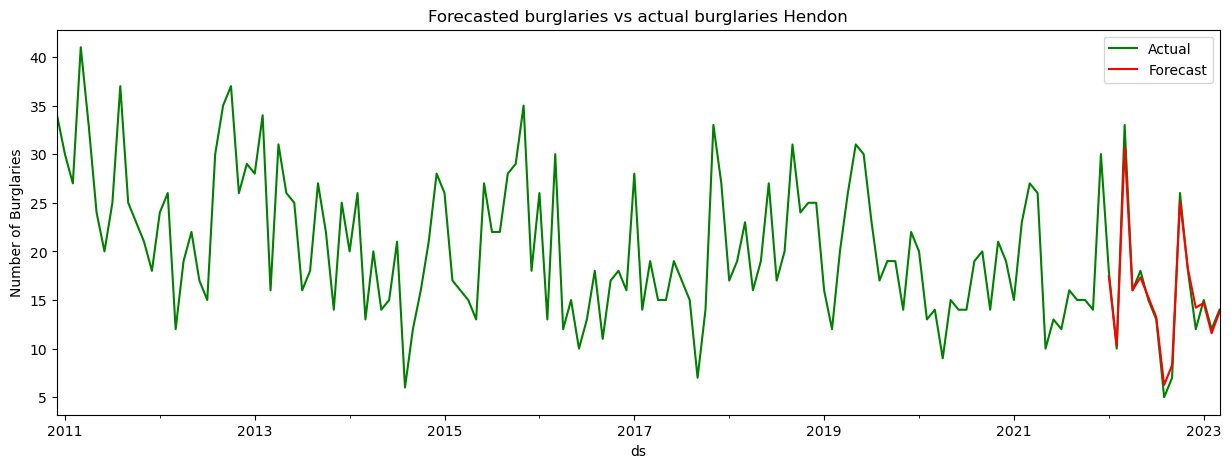

C:\Users\20203697\AppData\Local\Temp\ipykernel_21228\3932083734.py:28: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

16:52:19 - cmdstanpy - INFO - Chain [1] start processing
16:52:20 - cmdstanpy - INFO - Chain [1] done processing


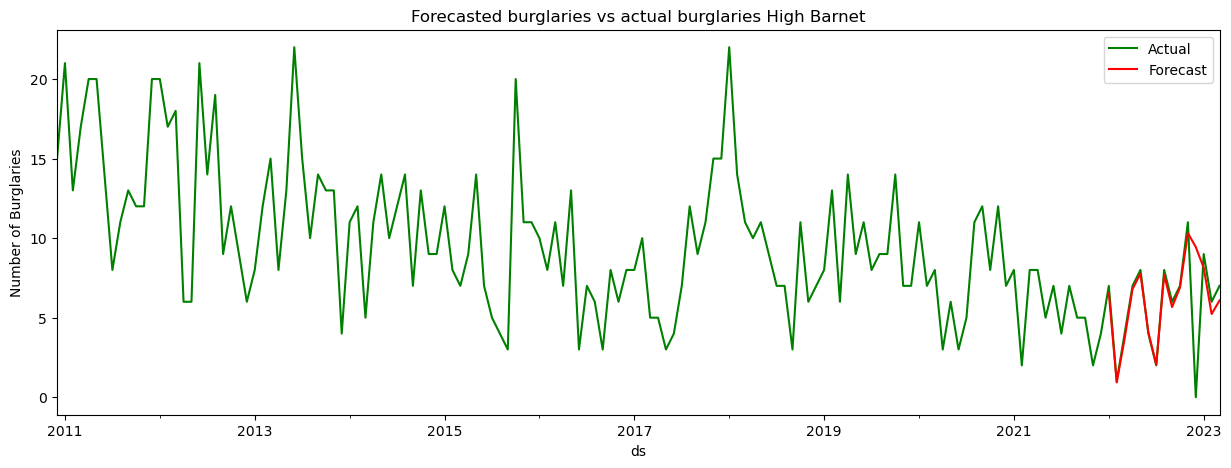

C:\Users\20203697\AppData\Local\Temp\ipykernel_21228\3932083734.py:28: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

16:52:20 - cmdstanpy - INFO - Chain [1] start processing
16:52:21 - cmdstanpy - INFO - Chain [1] done processing


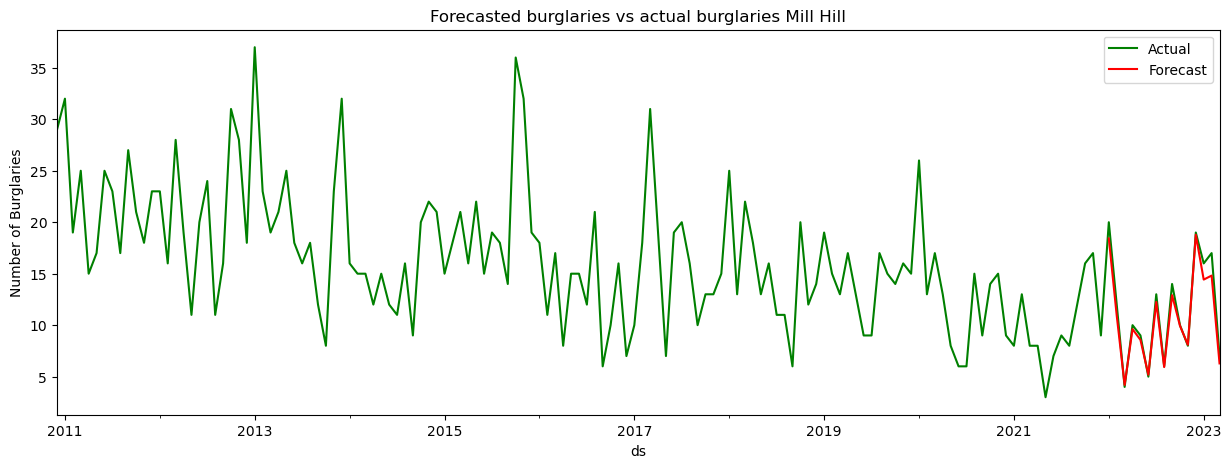

C:\Users\20203697\AppData\Local\Temp\ipykernel_21228\3932083734.py:28: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

16:52:21 - cmdstanpy - INFO - Chain [1] start processing
16:52:21 - cmdstanpy - INFO - Chain [1] done processing


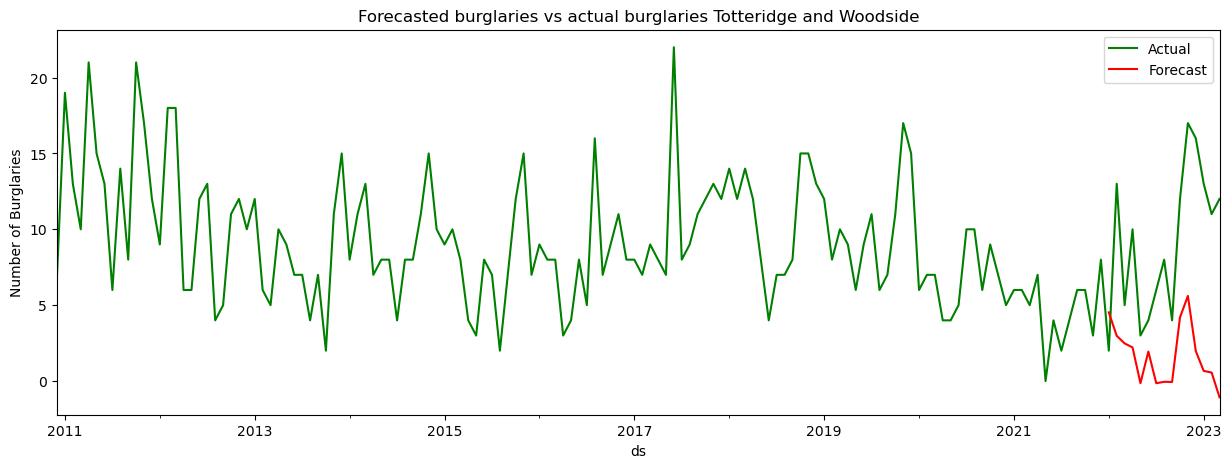

C:\Users\20203697\AppData\Local\Temp\ipykernel_21228\3932083734.py:28: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

16:52:22 - cmdstanpy - INFO - Chain [1] start processing
16:52:22 - cmdstanpy - INFO - Chain [1] done processing


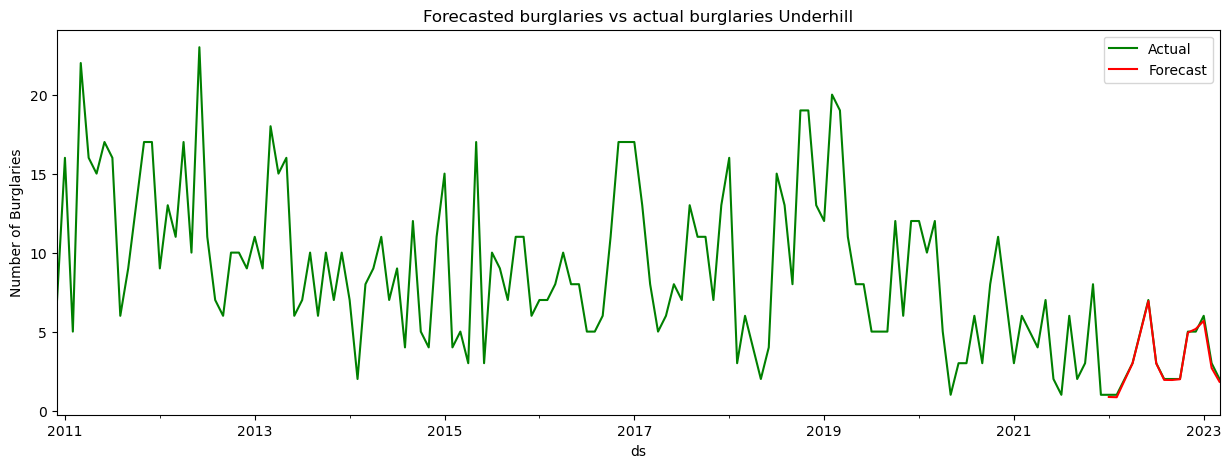

C:\Users\20203697\AppData\Local\Temp\ipykernel_21228\3932083734.py:28: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

16:52:23 - cmdstanpy - INFO - Chain [1] start processing
16:52:23 - cmdstanpy - INFO - Chain [1] done processing


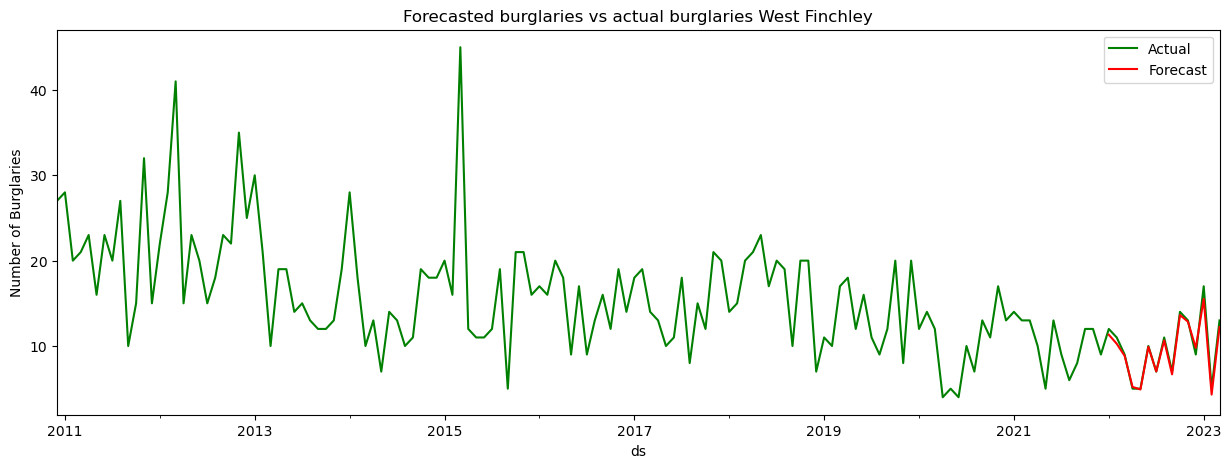

C:\Users\20203697\AppData\Local\Temp\ipykernel_21228\3932083734.py:28: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

16:52:24 - cmdstanpy - INFO - Chain [1] start processing
16:52:24 - cmdstanpy - INFO - Chain [1] done processing


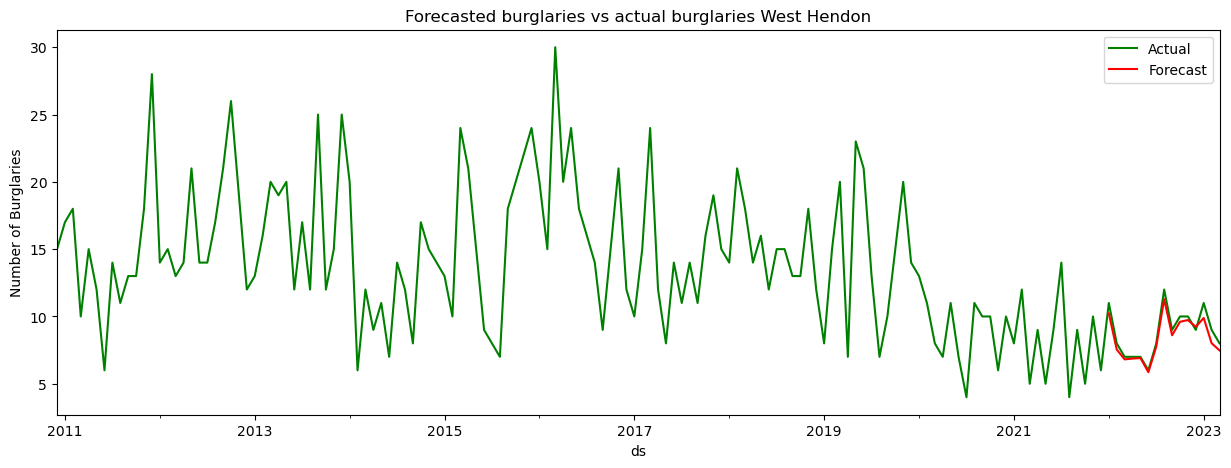

C:\Users\20203697\AppData\Local\Temp\ipykernel_21228\3932083734.py:28: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

16:52:25 - cmdstanpy - INFO - Chain [1] start processing
16:52:26 - cmdstanpy - INFO - Chain [1] done processing


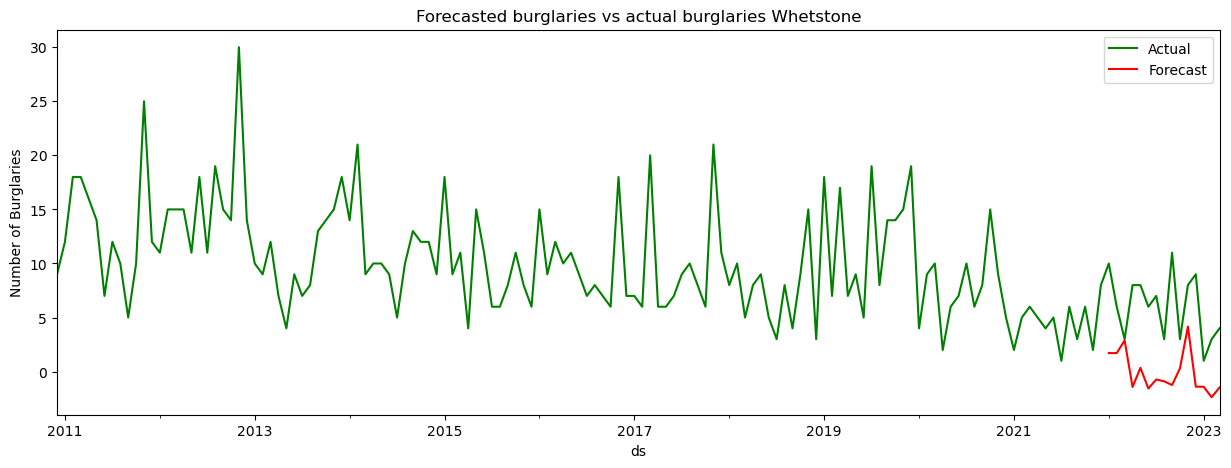

C:\Users\20203697\AppData\Local\Temp\ipykernel_21228\3932083734.py:28: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

16:52:27 - cmdstanpy - INFO - Chain [1] start processing
16:52:27 - cmdstanpy - INFO - Chain [1] done processing


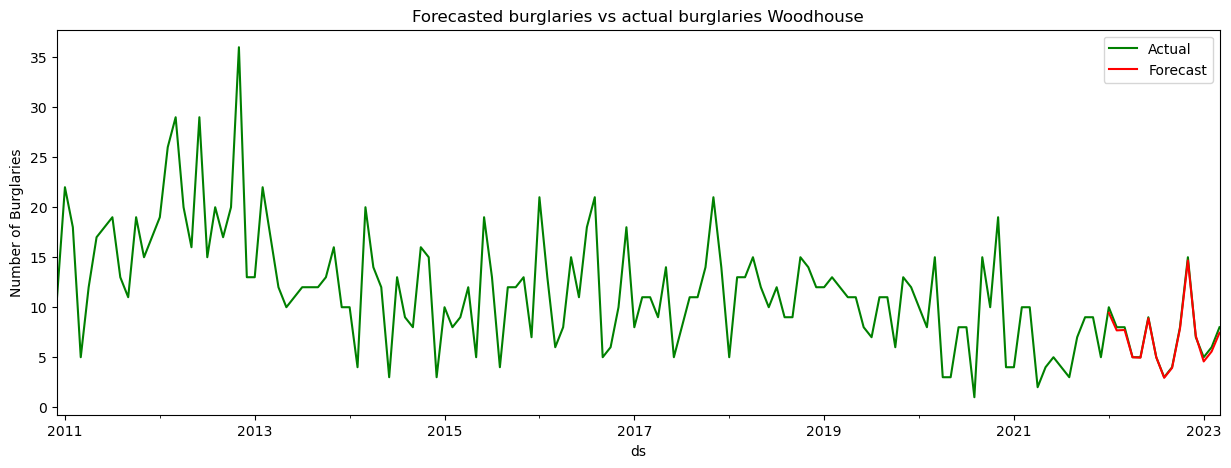

Mean MAE 1.63333370900515
MAES [3.2254500433292113, 0.25167288873281773, 0.17971595244869581, 0.4828238657500287, 1.7843211536113313, 3.455984908299801, 3.88755954348252, 0.28185553814465497, 0.4184638264563218, 0.48681339369292026, 1.9385918817098575, 0.3295057010394828, 4.446606600316745, 0.27380113756214325, 0.29481954959912127, 0.7442921473481161, 0.9878198887484033, 0.705982583700612, 7.690819089538548, 0.11147549393918149, 0.46027767167949685, 0.44240185492571976, 6.090100960930117, 0.22885334113775607]
MSES [17.632068196242397, 0.1062933050146865, 0.05275887460287653, 0.33885900906657335, 7.4922272330565285, 17.870589213629327, 22.326559496729942, 0.1612565335891656, 0.24497839471690688, 0.33856312658216925, 5.280073635872456, 0.18915696356257422, 27.508064933557005, 0.10601314951166392, 0.1434489834860481, 1.0396531577771928, 6.153584782446917, 0.9065574049062767, 75.07405458082306, 0.021327235860989443, 0.35883221530675957, 0.29136675495973097, 47.38733357308639, 0.08812753455

In [6]:
# Create a dataframe with the wanted dates
dates = pd.date_range(start='12/1/2010', end='3/1/2023', freq='MS').to_frame()

# Specify columns: ds, y, Date
df_per_ward['day'] = 1
df_per_ward = df_per_ward.reset_index()
df_per_ward = df_per_ward.rename(columns={'Month num': 'month', 'Year': 'year'})
df_per_ward['ds'] = pd.to_datetime(df_per_ward[['year', 'month', 'day']])
df_per_ward['Date'] = df_per_ward['ds']
dates['Date'] = dates[0]
dates = dates[['Date']]

# Loop over wards
wards = ['Barnet Vale', 'Brunswick Park', 'Burnt Oak', 'Childs Hill', 'Colindale North', 'Colindale South', 'Cricklewood', 'East Barnet', 'East Finchley', 'Edgware', 'Edgwarebury','Finchley Church End', 'Friern Barnet', 'Garden Suburb', 'Golders Green', 'Hendon','High Barnet', 'Mill Hill', 'Totteridge and Woodside', 'Underhill', 'West Finchley', 'West Hendon', 'Whetstone', 'Woodhouse']
mse = []
mae = []
r2 = []

print(len(wards))
for ward in wards: 
       # Select data of ward
       df_ward = df_per_ward[df_per_ward['Ward']==ward]
       df_ward = df_ward[['ds', 'Date', 'year', 'y', 'Population per square kilometre','covid']]
       # Merge with all dates to have a consistent dataframe
       df_ward = pd.merge(dates, df_ward, how="left", on='Date')
       df_ward['ds'] = df_ward['Date']
       df_ward['y'] = df_ward['y'].fillna(0)
       df_ward = df_ward.fillna(df_ward.mean())
       df_ward['year'] = pd.DatetimeIndex(df_ward['Date']).year
       train_ward = df_ward[df_ward['year']<(training_upto+1)]
       test_ward = df_ward[(df_ward['year']>training_upto)] 
       best_model = Prophet(seasonality_mode= 'additive', changepoint_prior_scale= 15, seasonality_prior_scale= 15, holidays_prior_scale= 30, holidays= holiday)
       best_model.add_regressor('Population per square kilometre')
       best_model.fit(train_ward)
       future_dates = best_model.make_future_dataframe(periods=forecast_upto, freq='MS')
       future_dates = pd.merge(future_dates, df_ward, how="left", on='ds')
       forecast = best_model.predict(future_dates[-forecast_upto:])
       mae.append(mean_absolute_error(test_ward['y'], forecast['yhat']))
       mse.append(mean_squared_error(test_ward['y'], forecast['yhat']))
       r2.append(r2_score(test_ward['y'], forecast['yhat']))
       f, ax = plt.subplots(figsize=(14,5))
       f.set_figheight(5)
       ax.set_xlabel("Year")
       ax.set_ylabel("Number of Burglaries")
       f.set_figwidth(15)
       
       df_ward.plot(kind='line',x='ds',y='y', color='green',label='Actual', ax=ax)
       forecast[-forecast_upto:].plot(kind='line',x='ds', y='yhat', color='red', label='Forecast', ax=ax)
       title = 'Forecasted burglaries vs actual burglaries ' + ward
       plt.title(title)
       plt.show()

print("Mean MAE", np.mean(mae))
print("MAES", mae)
print("MSES", mse)
print("r2", r2)